# Multilayer perceptron

Pytorch framework documentation [here](https://pytorch.org/)

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

from tqdm import tqdm
from keras.utils import to_categorical

import torch
import torch.nn as nn
from torchsummary import summary

## Load data - [MNIST](http://yann.lecun.com/exdb/mnist/)

In [10]:
# Load MNIST data
data_train = pd.read_csv( '/content/sample_data/mnist_train_small.csv',header=None)
data_test = pd.read_csv('/content/sample_data/mnist_test.csv',header=None)

X_train = np.array(data_train.iloc[:,1:])
X_test = np.array(data_test.iloc[:,1:])
y_train = np.array(data_train.iloc[:,0])
y_test = np.array(data_test.iloc[:,0])

print (X_train.shape, y_train.shape, X_test.shape,y_test.shape)

(20000, 784) (20000,) (10000, 784) (10000,)


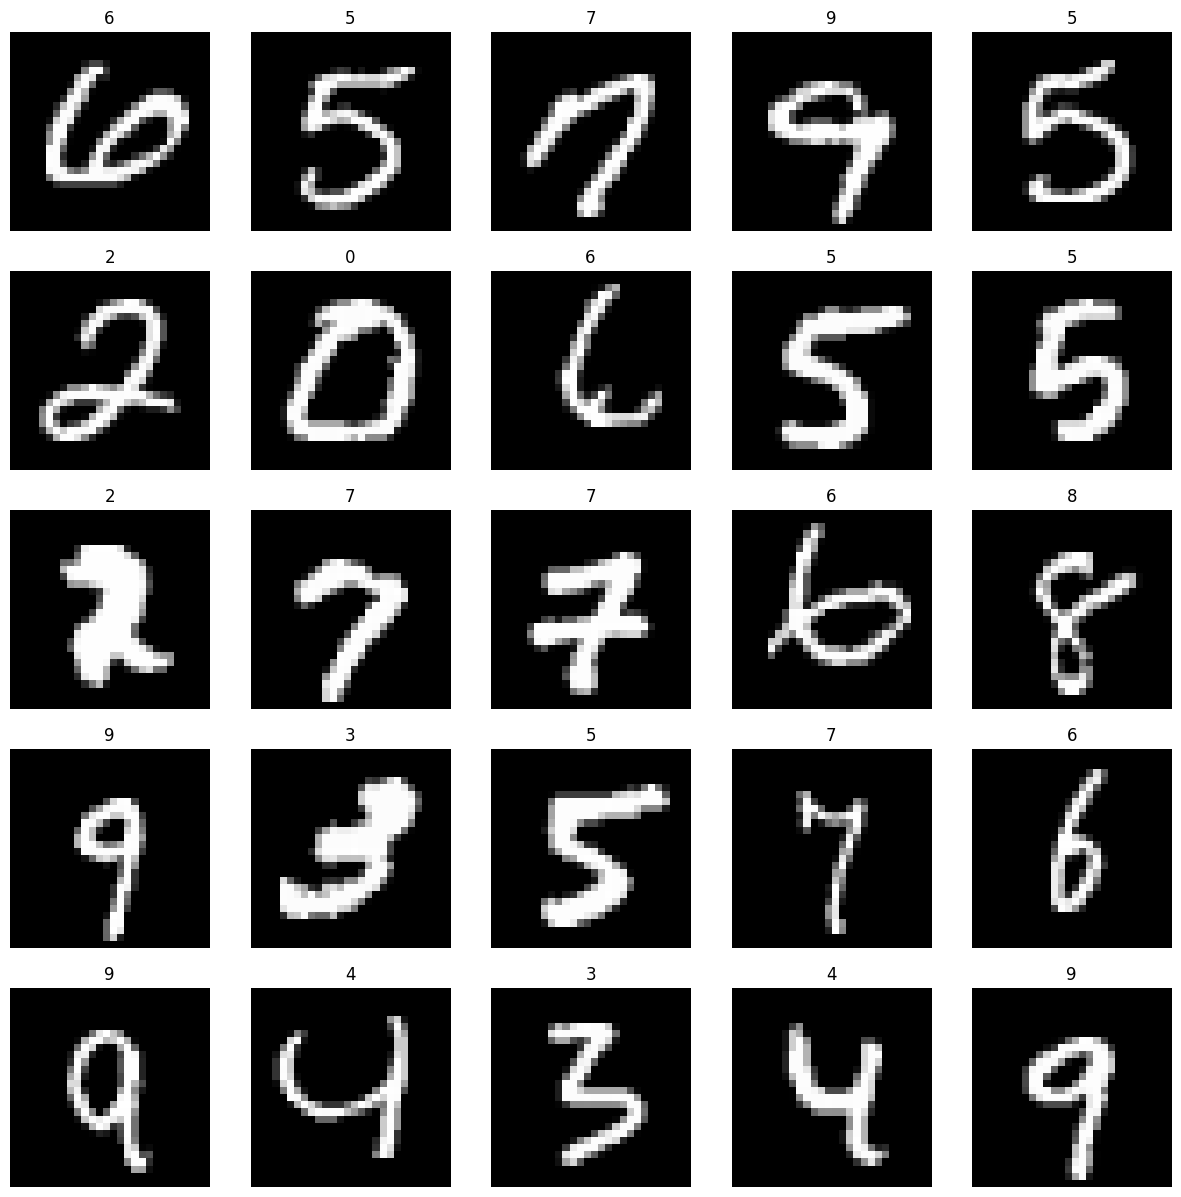

In [11]:
# Visualize grid of samples
grid_size = (5,5)

_, axes = plt.subplots ( grid_size[0] , grid_size[1] , figsize=(grid_size[0]*3,grid_size[1]*3))

axes = axes.ravel()

for i, ax in enumerate(axes):
  ax.imshow( X_train[i].reshape([28,28]) , cmap='gray')
  ax.set_axis_off()
  ax.set_title(str(y_train[i]))


In [12]:
# Reshape the data - MLPs do not understand such '2D' stuff
# Reshape to 1D is similat to "flatten" an image

# Configuration options
feature_vector_length = 784
num_classes = 10

# Convert into 0 - 1 values
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

In [13]:
# Convert target classes to categorical ones - one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Create a graph model

In [55]:
# Model params for training
epochs = 100
batch_size = 200 # We dont train the whole dataset at the time
losses = []

model = nn.Sequential(
    nn.Linear( feature_vector_length , 392 ), nn.ReLU(),
    nn.Linear( 392 , 191 ), nn.ReLU(),
    nn.Linear( 191 , 95 ), nn.ReLU(),
    nn.Linear( 95 , 47 ), nn.ReLU(),
    nn.Linear( 47 , 23 ), nn.ReLU(),
    nn.Linear( 23 , num_classes ), nn.Softmax()
)

summary(model, input_size=(784,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 392]         307,720
              ReLU-2                  [-1, 392]               0
            Linear-3                  [-1, 191]          75,063
              ReLU-4                  [-1, 191]               0
            Linear-5                   [-1, 95]          18,240
              ReLU-6                   [-1, 95]               0
            Linear-7                   [-1, 47]           4,512
              ReLU-8                   [-1, 47]               0
            Linear-9                   [-1, 23]           1,104
             ReLU-10                   [-1, 23]               0
           Linear-11                   [-1, 10]             240
          Softmax-12                   [-1, 10]               0
Total params: 406,879
Trainable params: 406,879
Non-trainable params: 0
-------------------------------

## Define loss function and optimizer

In [61]:
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1 )

## Train model

In [62]:
progress = tqdm(range(epochs), ncols=110)

for epoch in progress:# Iterate over all the num of epochs
  #

  batch_losses = 0

  for batch_i in range(0,len(X_train), batch_size):# Iterate over all batches of data
    #
    # First step, take the data from the dataset
    batch_X = X_train[batch_i : batch_i + batch_size]
    batch_y = y_train[batch_i : batch_i + batch_size]
    batch_X = torch.from_numpy(batch_X).to(torch.float32) # Convert to torch tensor to feed the graph
    batch_y = torch.from_numpy(batch_y).to(torch.float32) # Convert to torch tensor to feed the graph

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    predictions = model(batch_X)

    # Compute loss
    batch_loss = loss(predictions, batch_y)

    # Perform backward pass
    batch_loss.backward()

    # Optimize parameters
    optimizer.step()

    ## Accumulate loss to compute mean over all batches
    batch_losses += batch_loss.item()

    # Compute time and show all progress
    progress.set_description("[Epoch %d/%d] [Batch %d/%d] [Loss: %f] " % (epoch, epochs,
                                                                          batch_i, len(X_train),
                                                                          batch_loss.item()))

  # Save epoch loss
  losses.append(batch_losses/(len(X_train)/batch_size))




  0%|                                                                                 | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
[Epoch 99/100] [Batch 19800/20000] [Loss: 0.090031] : 100%|█████████████████| 100/100 [01:32<00:00,  1.08it/s]


## Plot results

Text(0.5, 0, 'Epoch')

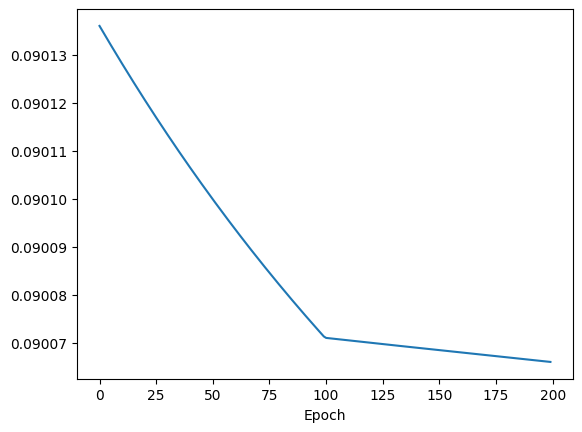

In [63]:
# Plot progress (loss function)
import seaborn as sns

plt.plot(np.array(losses))
plt.xlabel("Epoch")

## Compute metrics over ```X_test``` images

In [64]:
progress = tqdm(range( 0 , len(X_test) , batch_size ), ncols=100)
predictions = []

for batch_i in progress: # Iterate over all batches of data
  #
  batch_X = X_test[batch_i : batch_i + batch_size]
  batch_y = y_test[batch_i : batch_i + batch_size]
  batch_X = torch.from_numpy(batch_X).to(torch.float32) # Convert to torch tensor to feed the graph
  batch_y = torch.from_numpy(batch_y).to(torch.float32)

  # Perform forward pass to compute predictions
  batch_predictions = model(batch_X)
  predictions.extend(batch_predictions.detach().numpy())

predictions = np.argmax(np.array(predictions),axis=1)

100%|██████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 371.48it/s]


Accuracy: 0.1032


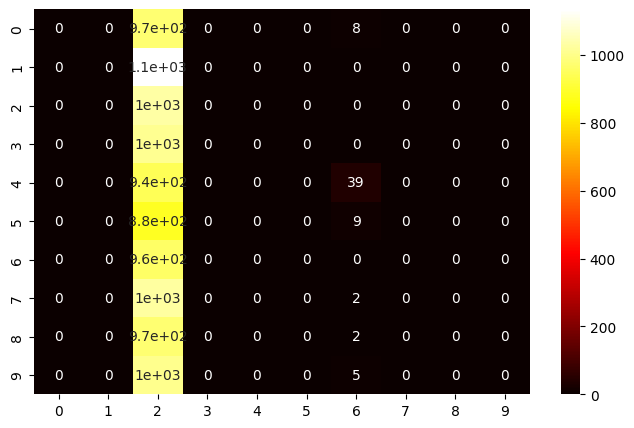

In [65]:

y_test_ = np.argmax(y_test, axis=1)

acc = accuracy_score (y_test_, predictions)
cm_ = confusion_matrix(y_test_,predictions)

# Compute confusion matrix and accuracy
_, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_, cmap="hot", annot=True, ax=ax)
print("Accuracy: {0}".format(acc))